<a href="https://colab.research.google.com/github/hopefulhazel/programacion/blob/master/ResNet50_Imagenet_OwnImages2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fileId = drive.CreateFile({'id': '1FtyYD-L2zIQKD_EW3uco4QavZmDzkn9-'}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
#print (fileId['kategorize.zip'])  # folder_data.zip
#fileId.GetContentFile('kategorize.zip')  # Save Drive file as a local file

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import random 
import cv2

X_data = []
files = glob.glob ("/content/kategorize/22")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)

In [0]:
#fileId.GetContentFile('kategorize.zip')
!unzip -uq "/content/drive/My Drive/kategorize.zip" -d ./

In [0]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)  # list of desired augmentors

ig = ImageDataGenerator(preprocessing_function=seq.augment_image)  # pass this as the preprocessing function

gen = ig.flow_from_directory("/content/kategorize/")  # nothing else changes with the generator

images_aug = seq.augment_images(X_data)

Using TensorFlow backend.


Found 83152 images belonging to 24 classes.


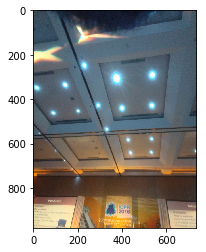

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content/kategorize"

CATEGORIES = ["0", "1","2","3","4","5", "6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]
#CATEGORIES = [num for num in range(24)]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

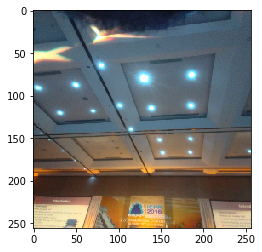

In [0]:
IMG_SIZE = 256

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [0]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat
        count = 0
       
        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                count += 1
                if count > 700 :
                    break
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 467/467 [00:04<00:00, 109.95it/s]

15448


In [0]:
print(len(training_data))

15448


In [0]:
import random
#haure de crear un trainning data amb tot y un amb subset despres de ferhi un shuffle, sino no te molt sentit
random.shuffle(training_data)

In [0]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [0]:
np.save('X', X)
np.save('y', y)

In [0]:
ls

adc.json  drive/  kategorize/  sample_data/  X.npy  y.npy


In [0]:
#fi primera part

In [0]:
import random
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, GaussianNoise
from keras.optimizers import SGD, Adam, Adagrad, Adadelta
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pickle

import sklearn
from sklearn.model_selection import train_test_split



X = np.load('X.npy')

y = np.load('y.npy')

#n = 6383
#n_train = int(round(n * 0.8))
#n_test = int(round(n * 0.2))
#print(y_train)
#print(n_test)
#print(X.shape)
#print(x_test.shape[0])
# limit the amount of the data
# train data



x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)






  
  
#ind_train = random.sample(list(range(x_train.shape[0])), n_train)
#x_train = x_train[ind_train]
#y_train = y_train[ind_train]

# test data
#ind_test = random.sample(list(range(x_test.shape[0])), n_test)
#x_test = x_test[ind_test]
#y_test = y_test[ind_test]

Using TensorFlow backend.


In [0]:
def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 320, 320, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(320, 320), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

# resize train and  test data
x_train_resized = x_train
x_test_resized = x_test

# make explained variable hot-encoded
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)


print([y_train_hot_encoded[0]])
print([y_train_hot_encoded[5]])
print([y_train_hot_encoded[200]])


print([y_test_hot_encoded[0]])
print(np.argmax(y_test_hot_encoded[0]))
print([y_test_hot_encoded[5]])
print(np.argmax(y_test_hot_encoded[5]))
print([y_test_hot_encoded[200]])


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0.], dtype=float32)]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0.], dtype=float32)]
17
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
11
[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)]


In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from sklearn.metrics import confusion_matrix
def model(x_train, y_train, x_test, y_test, base_model, optimizer, loss_func, dropout, batch_size, frozen_layers):

    # get layers and add average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add fully-connected layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout)(x)

    # add output layer
    predictions = Dense(24, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze pre-trained model area's layer
    for layer in base_model.layers:
        layer.trainable = False

    # update the weight that are added
    model.compile(optimizer=optimizer, loss=loss_func)
    model.fit(x_train, y_train)

    # choose the layers which are updated by training
    layer_num = len(model.layers)
    for layer in model.layers[:int(layer_num * frozen_layers)]:
        layer.trainable = False

    for layer in model.layers[int(layer_num * frozen_layers):]:
        layer.trainable = True

    # update the weights
    model.compile(optimizer=optimizer, loss=loss_func, metrics=['acc', recall_m, precision_m, f1_m])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)
    
    result=model.predict(x_test)
    
    #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size, epochs=25, verbose=1, validation_data=(x_test,y_test))
    #history = model.fit_generator(generator(x_train, y_train, batch_size), steps_per_epoch = x_train.shape[0] / batch_size, epochs=50, validation_data=(x_test, y_test))
    return history, result

https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras

this my work

### Data augmentation

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(x_train)

In [0]:
from random import randint
np.random.seed(123)

def generator(features, labels, batch_size):
  
    # create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, 200, 200, 3))
    batch_labels = np.zeros((batch_size, 24))

    while True:

        for i in range(batch_size):
            # choose random index in features
            index = np.random.randint(0, len(features)-1)
            random_augmented_image, random_augmented_label = features[index], labels[index]
            batch_features[i] = random_augmented_image
            batch_labels[i] = random_augmented_label

        yield batch_features, batch_labels

NameError: ignored

###Hyperparameters

In [0]:
res_50_model = ResNet50(weights='imagenet', include_top=False)

#Hyperparameters
learning_rate = 1.0
optimizer = Adadelta(lr=learning_rate, rho=0.95, epsilon=None, decay=0.0)
#optimizer = Adagrad(learning_rate)
loss_func = 'binary_crossentropy' # binary_crossentropy, categorical_hinge or categorical_crossentropy
dropout = 0.4
batch_size = 64
frozen_layers = 0.9

history_res_50_1, result = model(x_train_resized, y_train_hot_encoded, x_test_resized, y_test_hot_encoded, res_50_model, optimizer, loss_func, dropout, batch_size, frozen_layers)
print(result)
#history_res_50_2 = model(x_train_resized, y_train_hot_encoded, x_test_resized, y_test_hot_encoded, res_50_model, optimizer, loss_func, dropout, batch_size, frozen_layers)

#history_res_50_3 = model(x_train_resized, y_train_hot_encoded, x_test_resized, y_test_hot_encoded, res_50_model, optimizer, loss_func, dropout, batch_size, frozen_layers)

#history_res_50_4 = model(x_train_resized, y_train_hot_encoded, x_test_resized, y_test_hot_encoded, res_50_model, optimizer, loss_func, dropout, batch_size, frozen_layers)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
10813/10813 [==============================] - 115s 11ms/step - loss: 0.0924
Train on 10813 samples, validate on 4635 samples
Epoch 1/10
10813/10813 [==============================] - 177s 16ms/step - loss: 0.0525 - acc: 0.9820 - recall_m: 0.6752 - precision_m: 0.8638 - f1_m: 0.7560 - val_loss: 0.0733 - val_acc: 0.9763 - val_recall_m: 0.6235 - val_precision_m: 0.7631 - val_f1_m: 0.6850
Epoch 2/10
10813/10813 [==============================] - 173s 16ms/step - loss: 0.0293 - acc: 0.9900 - recall_m: 0.8291 - precision_m: 0.9230 - f1_m: 0.8728 - val_loss: 0.0825 - val_acc: 0.9769 - val_recall_m: 0.6576 - val_precision_m: 0.7568 - val_f1_m: 0.7029
Epoch 3/10
10813/10813 [==============================] - 173s 

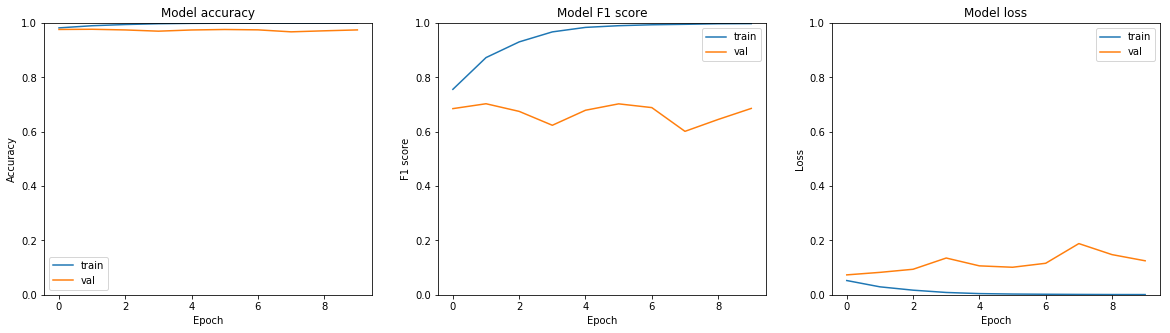

In [0]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

# plot history
ax1.set_ylim([0,1])
ax1.plot(history_res_50_1.history['acc'], label='train')
ax1.plot(history_res_50_1.history['val_acc'], label='val')
ax1.legend()
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.set_ylim([0,1])
ax2.plot(history_res_50_1.history['f1_m'], label='train')
ax2.plot(history_res_50_1.history['val_f1_m'], label='val')
ax2.legend()

ax2.set_title('Model F1 score')
ax2.set_ylabel('F1 score')
ax2.set_xlabel('Epoch')

ax3.set_ylim([0,1])
ax3.plot(history_res_50_1.history['loss'], label='train')
ax3.plot(history_res_50_1.history['val_loss'], label='val')
ax3.legend()
ax3.set_title('Model loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')

fig.patch.set_facecolor('xkcd:white')
plt.savefig('results.png')
plt.show()

## Confusion matrix

In [0]:
len(y_test)

4635

In [0]:
m=np.zeros((24,24))
z=np.zeros((24,24))

for k in range(0, len(y_test)):
    i=np.argmax(y_test_hot_encoded[k])
    j=np.argmax(result[k])
    m[i][j] += 1
    z[j][i] += 1
print(m)
    
    

[[192.   0.   0.   4.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.
    0.   0.   0.   5.   0.   3.   0.   0.   0.   0.]
 [  1. 180.   1.   1.   0.   0.   1.   0.   1.   0.   0.   0.   8.   0.
    0.   0.  17.   7.   1.   3.   0.   1.   0.   1.]
 [  4.   1. 202.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.
    0.   0.   0.   9.   1.   2.   0.   0.   0.   0.]
 [  1.   0.   0. 170.   0.  12.   0.   0.   5.   0.   0.   0.   5.   0.
    0.   0.   0.   3.   0.   4.   0.   1.   0.   1.]
 [  5.   1.   2.   1. 135.   1.   3.   0.   4.   0.   0.   0.   2.   7.
    0.   0.   2.   5.   2.   4.  18.   1.   0.   1.]
 [  4.   0.   0.  15.   0. 105.   0.   0.   3.   0.   0.   0.   0.   1.
    0.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  9.   4.   1.   3.   0.   2. 120.   0.  27.   3.   0.   0.  12.  11.
    0.   0.   0.  15.   0.   2.   2.   1.   0.   0.]
 [  7.  14.  23.   0.   0.   8.   0. 131.   0.   0.   0.   0.   1.   2.
    0.   0.   0.  10.   0.   6.   0.   0.   0.   0.]


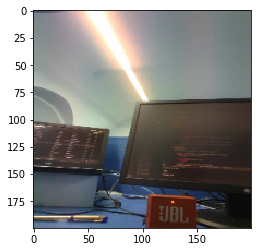

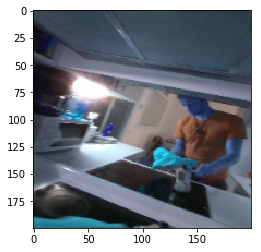

NameError: ignored

In [0]:
m=np.zeros((24,24))
z=np.zeros((24,24))
trp=[]
fp=[]
fn=[]
for k in range(0, len(y_test)):
    i=np.argmax(y_test_hot_encoded[k])
    j=np.argmax(result[k])
    m[i][j] += 1
    z[j][i] += 1
    



IMG_SIZE = 200

new_array = cv2.resize(x_test[0], (IMG_SIZE, IMG_SIZE))
trp.append(new_array)
new_array2 = cv2.resize(x_test[1], (IMG_SIZE, IMG_SIZE))
trp.append(new_array2)
plt.imshow(new_array)
plt.show()
plt.imshow(trp[1])
plt.show()

new_im = Image.new('RGB', (200,400))
#Here I resize my opened image, so it is no bigger than 100,100
k=0
#Iterate through a 4 by 4 grid with 100 spacing, to place my image
for i in range(0,200,200):
    for j in range(0,400,200):
        #paste the image at location i,j:
        
        new_im.paste(trp[k], (i,j))
        k+=1
        

new_im  

In [0]:
len(y_test_hot)

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(m, range(24),
                  range(24))
# df_cm = pd.DataFrame(m, index = [i for i in "012345678901234567890123"],
#                   columns = [i for i in "012345678901234567890123"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(m, range(24),
                  range(24))
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)

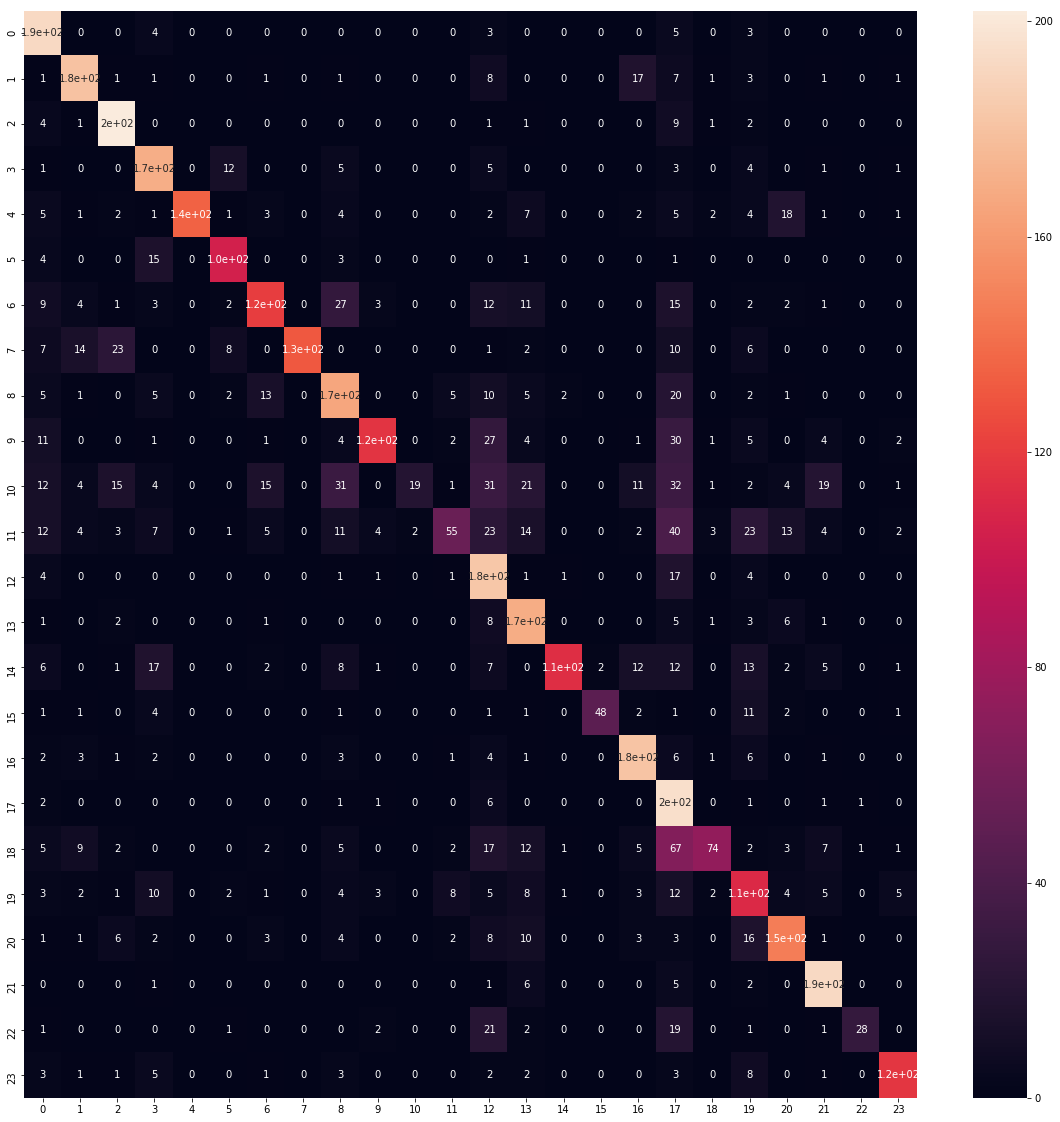

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(m, range(24),
                  range(24))
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)

# Normalized Confusion Matrix



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


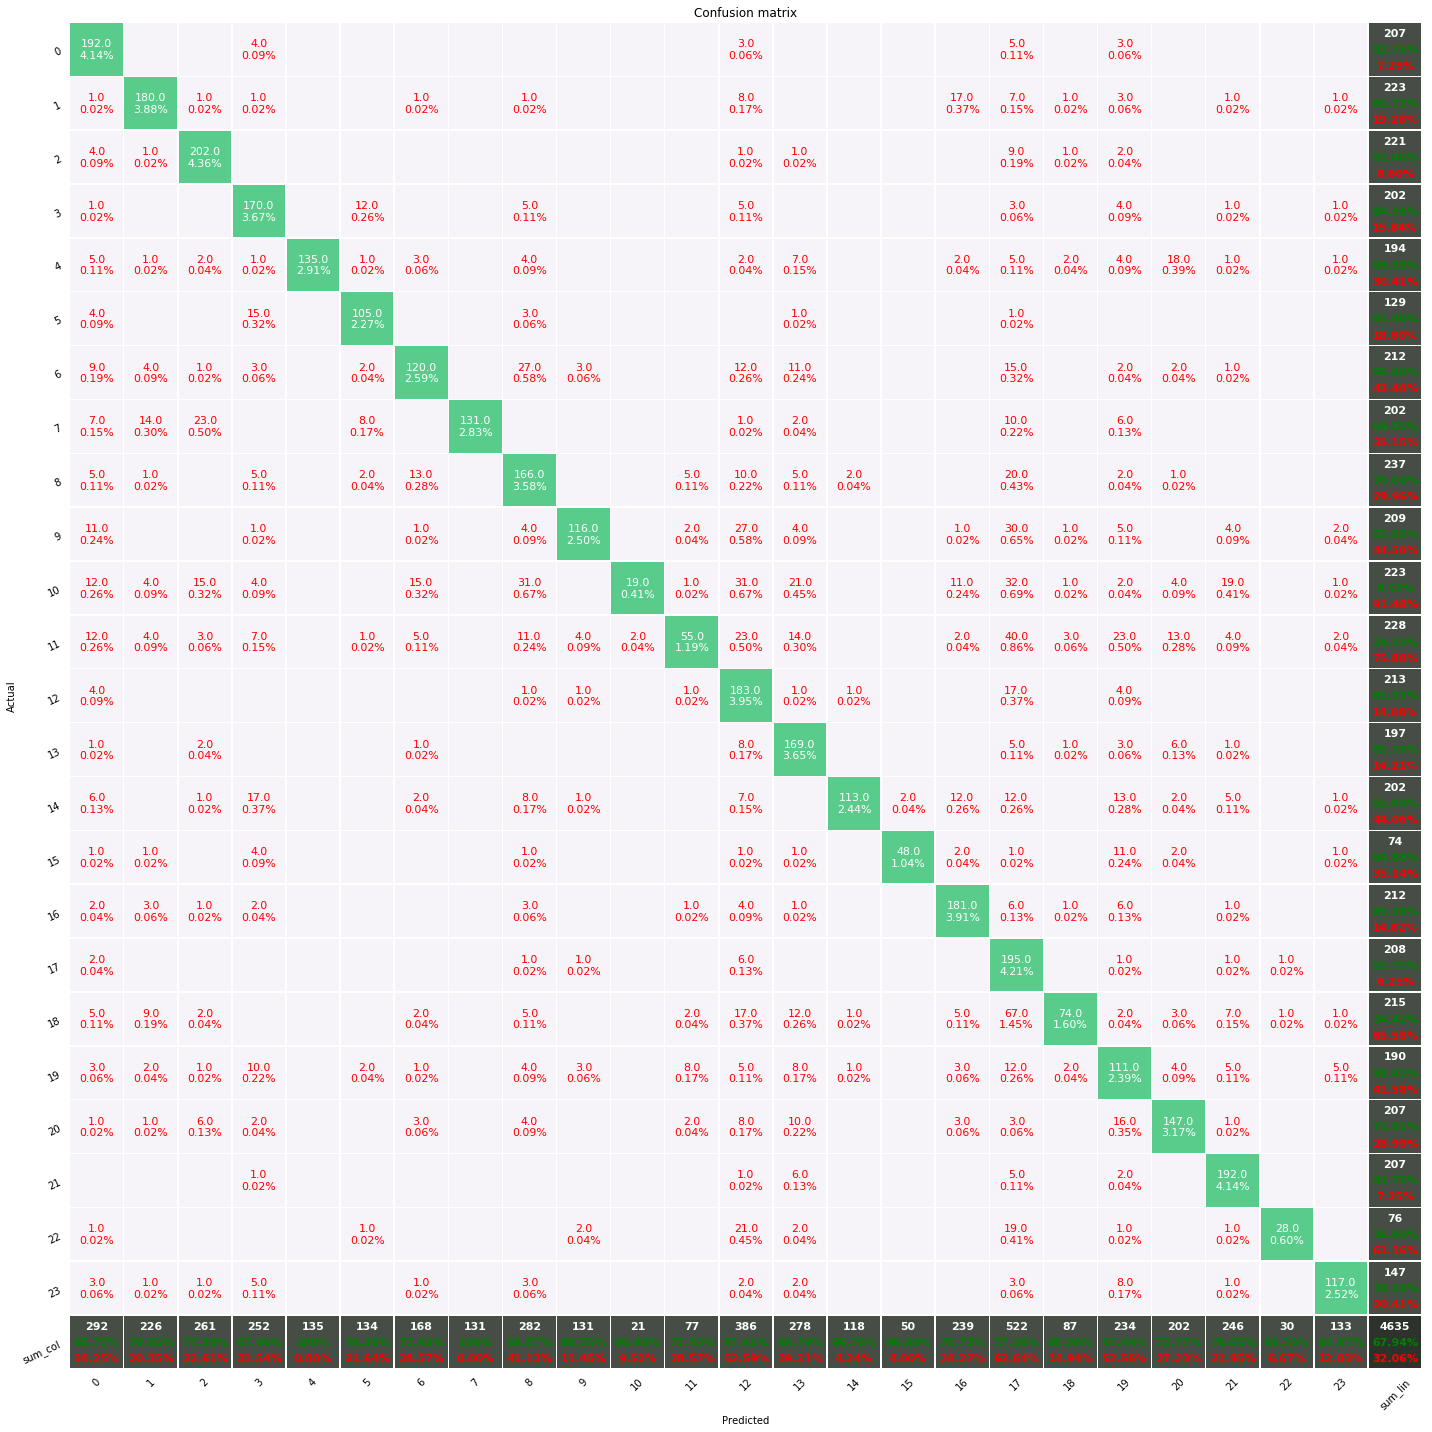

In [0]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[40,40]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[20,20], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        ylbl = 'Predicted'
        xlbl = 'Actual'
    else:
        ylbl = 'Actual'
        xlbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#
df_cm = DataFrame(z, index=range(0,24), columns=range(0,24))
    #colormap: see this and choose your more dear
cmap = 'PuRd'

pretty_plot_confusion_matrix(df_cm, cmap=cmap)


In [0]:
h=m

for i in range(0,24):
  sumfila=0
  for j in range(0,24):
    sumfila += h[i][j]
  for j in range(0,24):
    h[i][j]= h[i][j]/sumfila
print(h)

[[0.92753623 0.         0.         0.01932367 0.         0.
  0.         0.         0.         0.         0.         0.
  0.01449275 0.         0.         0.         0.         0.02415459
  0.         0.01449275 0.         0.         0.         0.        ]
 [0.0044843  0.80717489 0.0044843  0.0044843  0.         0.
  0.0044843  0.         0.0044843  0.         0.         0.
  0.03587444 0.         0.         0.         0.07623318 0.03139013
  0.0044843  0.01345291 0.         0.0044843  0.         0.0044843 ]
 [0.01809955 0.00452489 0.91402715 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00452489 0.00452489 0.         0.         0.         0.04072398
  0.00452489 0.00904977 0.         0.         0.         0.        ]
 [0.0049505  0.         0.         0.84158416 0.         0.05940594
  0.         0.         0.02475248 0.         0.         0.
  0.02475248 0.         0.         0.         0.         0.01485149
  0.         0.01980198 0.       

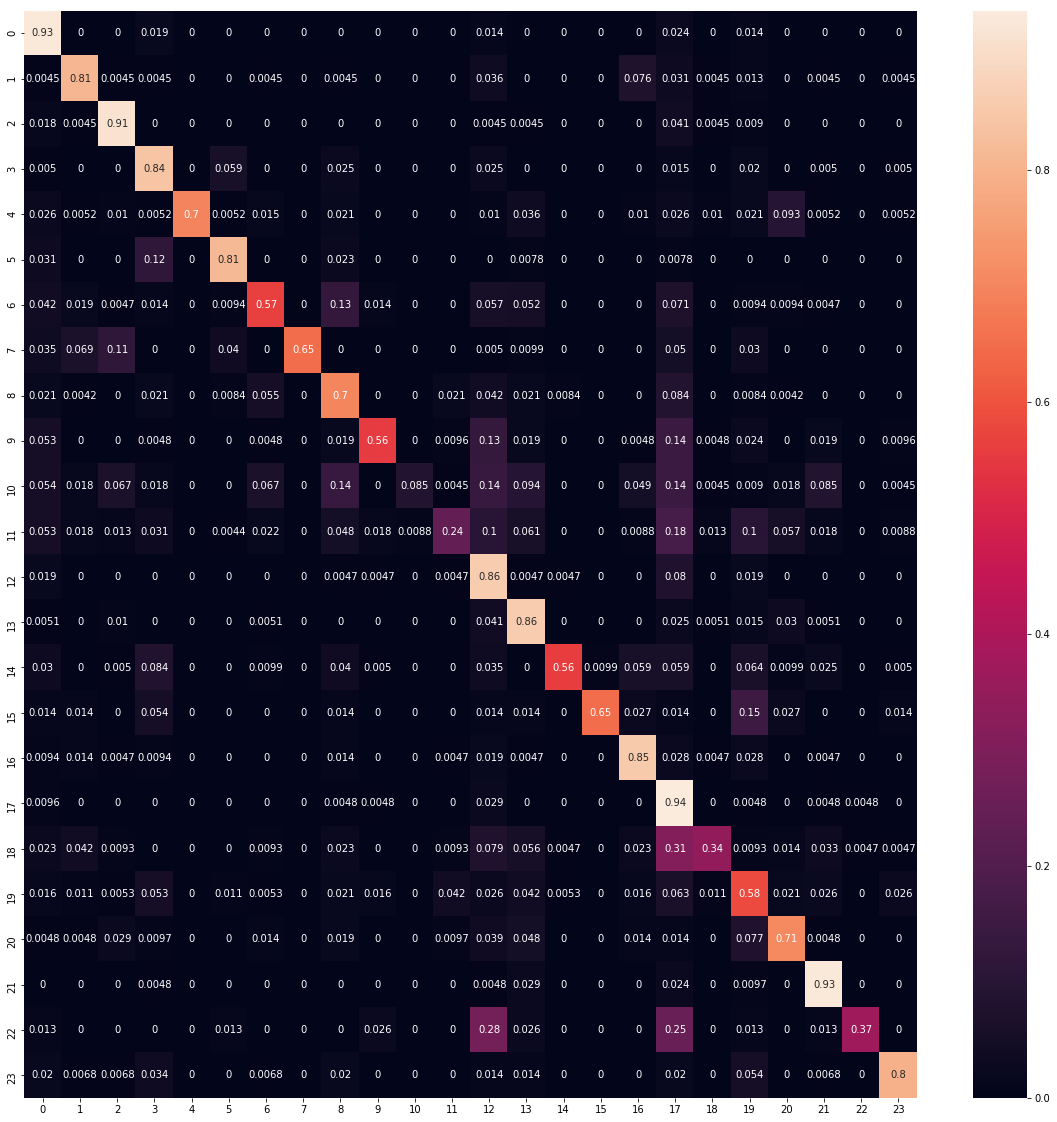

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(h, range(24),
                  range(24))
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)